In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [234]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [235]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-08-12 04:44:03--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.8’

insurance.csv.8     100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2021-08-12 04:44:03 (43.9 MB/s) - ‘insurance.csv.8’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [236]:
# quantify categorical values: sex, region, and smoker

# objects: hold assignments for unique sex, region, and smoker
sex_map, region_map, smoker_map = {}, {}, {}

# capture unique sex, region, and smoker
sexes = dataset['sex'].unique()
regions = dataset['region'].unique()
smokers = dataset['smoker'].unique()

# assign numbers to categorical values of sex, region, and smoker
for sex in range(len(sexes)):
  sex_map[sexes[sex]] = sex

for region in range(len(regions)):
  region_map[regions[region]] = region

for smoker in range(len(smokers)):
  smoker_map[smokers[smoker]] = smoker

# region_map
# sex_map

# replace categorical values in data set
dataset['sex'] = dataset['sex'].map(sex_map)
dataset['region'] = dataset['region'].map(region_map)
dataset['smoker'] = dataset['smoker'].map(smoker_map)
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,1,2,10600.55
1334,18,0,31.9,0,1,3,2205.98
1335,18,0,36.9,0,1,1,1629.83
1336,21,0,25.8,0,1,0,2007.95
1337,61,0,29.1,0,0,2,29141.36


In [ ]:
# outliers

# calculate summary statistics
data_mean, data_std = np.mean(dataset), np.std(dataset)
# identify outliers
# set cut off at std * 3
cut_off = data_std * 3
# change all expenses that are higher \
# than the upper cutoff expense to be the average expense
for expense in dataset['expenses']:
  if(expense > upper['expenses']):
    expense = data_mean['expenses']
print(data_mean, '\n', data_std)

In [238]:
# clean data
dataset.dropna()
dataset.shape

(1338, 7)

In [239]:
# create training and test data set
train_data = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_data.index)
train_data.shape, test_dataset.shape

((1070, 7), (268, 7))

In [240]:
# capture train_labels and test_labels
train_features = train_data.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')
print(train_features.shape)
print(train_labels.shape)

(1070, 6)
(1070,)


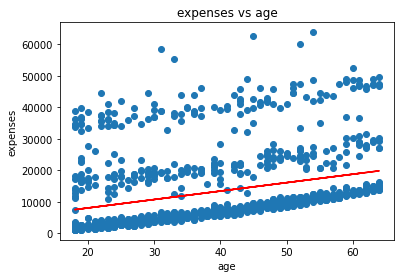

In [241]:
# plot training data
fig = plt.figure()
plt.scatter(train_data['age'], train_labels)
plt.title('expenses vs age')
plt.xlabel('age')
plt.ylabel('expenses')
m, b = np.polyfit(train_data['age'], train_labels, 1)
plt.plot(train_data['age'], m*train_data['age'] + b, 'red')

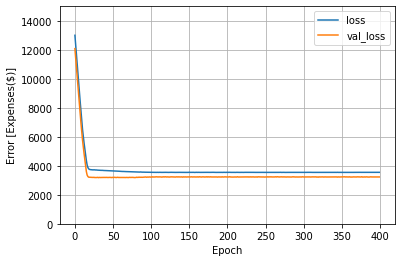

In [258]:
# Normalize data

# print(train_data.describe().transpose()[['mean', 'std']], '\n')

# Normalization layer
# coerces inputs into a distribution centered around 0 with std 1 \
# by precomputing the mean and variance of the data and calling \
# (input-mean)/sqrt(var) at runtime
normalizer = preprocessing.Normalization()

# adapt normalization layer to data
# compute mean and variance of data and store them as layer's weights
normalizer.adapt(np.array(train_features))

# sequential model
# # Regression
# # 1. Normalize the input 'bmi'
# # 2. Apply a linear transformation (y = m*x + b) to produce 1 output \
# # using layers.Dense
model = keras.models.Sequential([
  normalizer, # normalization layer
  layers.Dense(units=1) # Linear Regression model
])

# loss and optimizer
loss = keras.losses.MeanAbsoluteError()
optim = keras.optimizers.Adam(learning_rate = 25)

# single_feature_model.compile(optimizer=optim, loss=loss, metrics=['mse'])
model.compile(optimizer=optim, loss=loss)

history = model.fit(
    train_features, train_labels, 
    epochs=400,
    verbose=0,
    # calculate validation results on 20% of training data
    validation_split=0.2
)

# plot loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 15000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Expenses($)]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [253]:
m = model.evaluate(
    test_features,
    test_labels, verbose=2
)

9/9 - 0s - loss: 3153.7520


9/9 - 0s - loss: 3147.3945
Testing set Mean Abs Error: $3147.39 expenses
You passed the challenge. Great job!


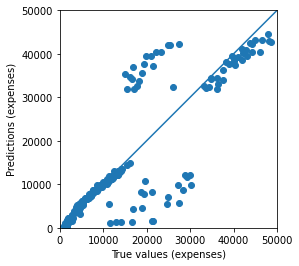

In [269]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.

mae = model.evaluate(test_features, test_labels, verbose=2)

print("Testing set Mean Abs Error: ${:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions
test_dataset.pop('expenses')
test_predictions = model.predict(test_dataset).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
